#### 3

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [5]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [6]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [7]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(11,0,0)
var_sarpdq   <-  c(2,0,0)
var_drift   <-  FALSE
var_constant   <-  TRUE

var_char  <-  c(4,2)

In [8]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=19, end=46)
# gts_test  <- window(y, start=47, end=54)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [26]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20317.2873  -5029.7177  -1399.2281  -2815.3946  -1874.4600   4523.1539
 [7]  12484.4918  19305.0873   9215.8569   7873.8252   6577.7476   1671.0580
[13] -10576.0174   1273.3622   2433.7384  -1805.1048   -444.3503   5321.2366
[19]  13998.4828  21286.8224  12906.0608  11676.0954   8657.0000   2084.6633
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100

In [27]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [28]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [29]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [30]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17543.501 -16707.855 -12060.477  -5403.454  -2447.611  15480.420
 [7]  17686.077   2873.435  -1555.882  -8588.390 -14117.739 -39449.691
[13] -20760.873 -18338.678 -14401.773 -14153.446  -7957.372   5141.846
[19]   4168.923  -9188.290 -12902.347 -20881.368 -29216.568 -51407.715

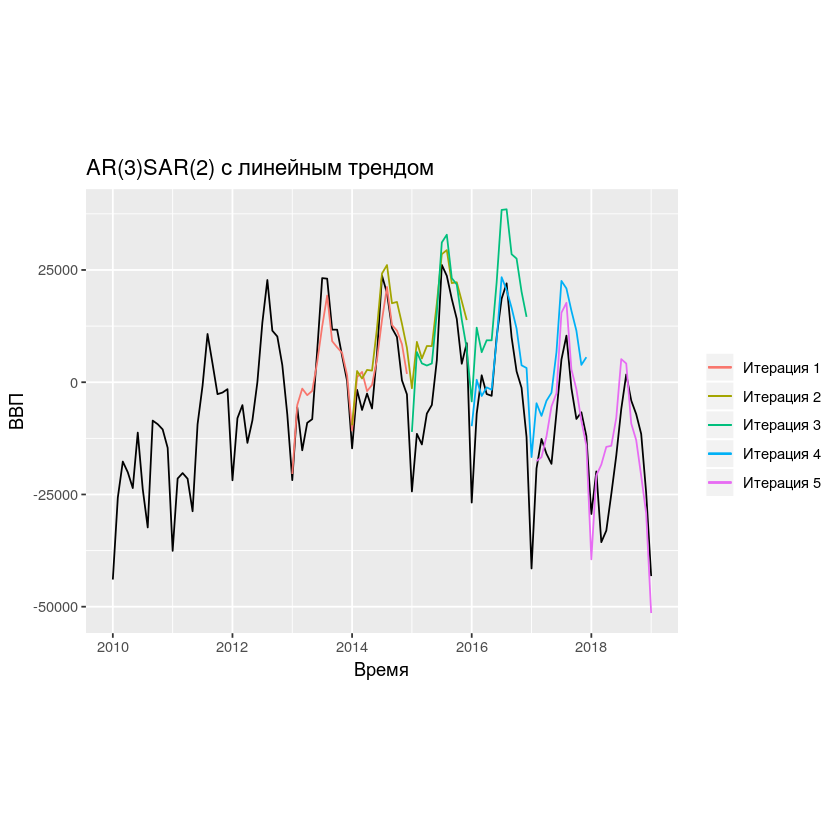

In [31]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [32]:
df_acc

ME,RMSE,MAPE,Iteration
-1472.047,5592.425,148.24050,1
-9172.417,10837.500,245.25158,13
-13412.454,15068.361,258.44532,25
-9995.499,12467.518,184.14611,37
-2812.203,8516.965,74.99428,50


In [33]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-7372.9240 10496.5540   182.2156    25.2000

In [34]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,NA
2 level (state),NA,242.5226,NA
2 level (type),NA,241.7866,NA
2 level (clusetered),NA,241.0673,NA


In [35]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,10496.554
2 level (state),NA,242.5226,NA
2 level (type),NA,241.7866,NA
2 level (clusetered),NA,241.0673,NA


In [36]:
df_acc

ME,RMSE,MAPE,Iteration
-1472.047,5592.425,148.24050,1
-9172.417,10837.500,245.25158,13
-13412.454,15068.361,258.44532,25
-9995.499,12467.518,184.14611,37
-2812.203,8516.965,74.99428,50


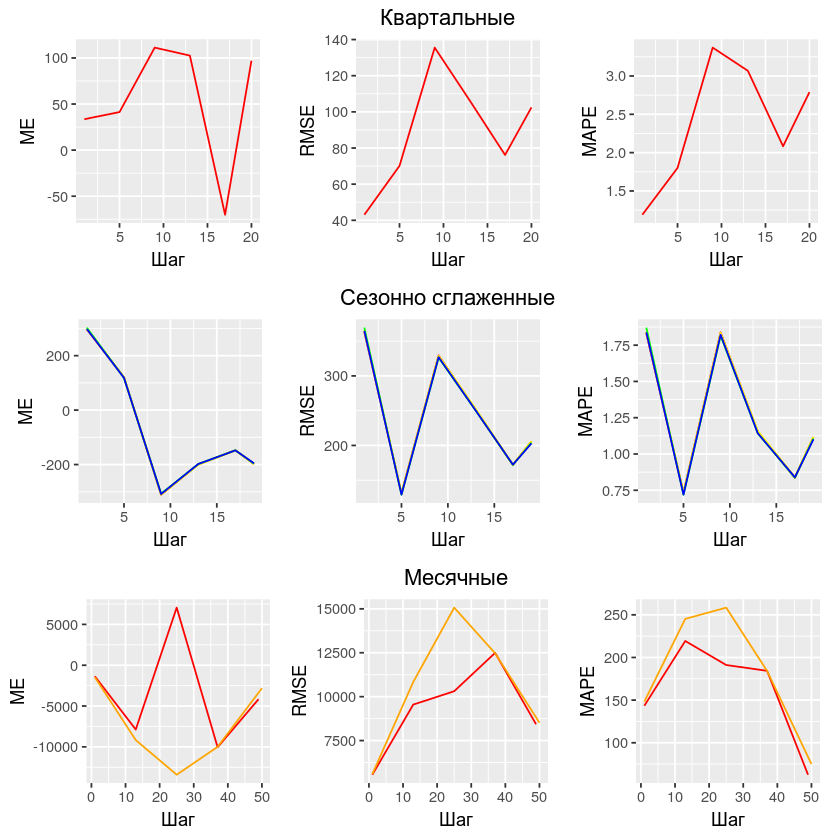

In [37]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [38]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [39]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [40]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [41]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20350.4033  -5035.5827  -1394.5372  -2822.3566  -1872.2545   4524.3471
 [7]  12459.5111  19314.6350   9200.3041   7843.7728   6576.7339   1650.7299
[13] -10613.6509   1266.1477   2413.3944  -1831.5936   -457.8128   5290.3857
[19]  13974.0544  21289.8167  12877.2081  11652.2082   8640.2215   2042.4846
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 12

Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -9545.4601  2479.0254   838.2482  2760.6018  2596.9096 12047.2548
 [7] 24152.0562 26021.0012 17563.5891 17845.5880 13008.8428  7654.6280
[13] -1314.8864  8952.6327  5282.3754  8059.8177  8042.6107 17492.7923
[19] 28420.0822 29321.4947 22021.6152 22187.5155 18013.6932 13812.4633
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11047.197   6592.171   4100.667   3698.997   4121.328  15368.301
 [7]  30937.167  32623.365  23018.559  21589.362  13806.411   7410.505
[13]  -4305.498  11990.587   6594.262   9230.803   9200.831  22010.680
[19]  38025.192  38152.028  28231.050  27231.104  19899.548  14346.115
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1]  -9805.2488    484.4743  -3099.3988  -1165.0087  -1696.1201   9286.8717
 [7]  23310.8043  20513.0405  16544.3369  11919.2177   3775.0996   3175.5742
[13] -16599.9077  -4682.8115  -7478.4084  -4114.5296  -2338.7337   6663.8076
[19]  22467.1267  20822.1950  15892.5457  11457.9203   3877.4762   5569.8701
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -17541.261 -16662.002 -12048.947  -5412.441  -2407.471  15442.474
 [7]  17623.341   2846.119  -1594.953  -8608.586 -14134.966 -39387.172
[13] -20768.268 -18325.587 -14411.521 -14156.326  -7962.691   5053.461
[19]   4083.823  -9225.071 -12951.740 -20901.901 -29191.774 -51303.142
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [50]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [51]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [52]:
df_acc

ME,RMSE,MAPE,Iteration
-1455.823,5590.685,147.60993,1
-9186.562,10848.932,245.69399,13
-13443.514,15100.054,259.04346,25
-10003.591,12473.827,184.36908,37
-2817.017,8524.446,75.17395,50


In [53]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17543.501 -16707.855 -12060.477  -5403.454  -2447.611  15480.420
 [7]  17686.077   2873.435  -1555.882  -8588.390 -14117.739 -39449.691
[13] -20760.873 -18338.678 -14401.773 -14153.446  -7957.372   5141.846
[19]   4168.923  -9188.290 -12902.347 -20881.368 -29216.568 -51407.715

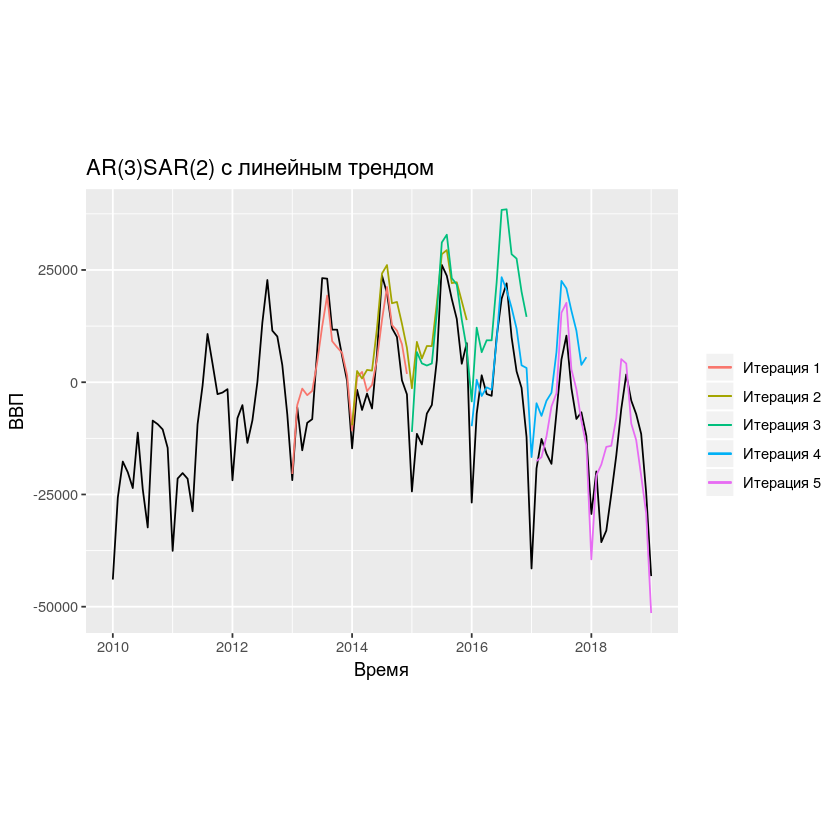

In [54]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [55]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-7381.3015 10507.5887   182.3781    25.2000

In [56]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [59]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,10496.554
2 level (state),NA,242.5226,10507.589
2 level (type),NA,241.7866,NA
2 level (clusetered),NA,241.0673,NA


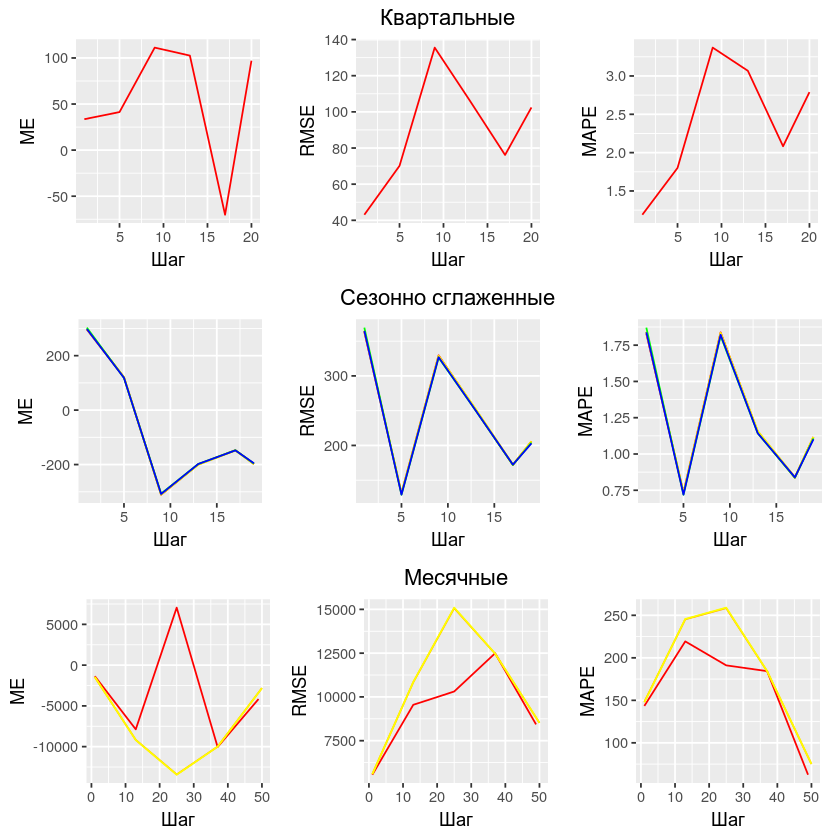

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [62]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [63]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [64]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [65]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -18308.9807  -3756.5325   -648.9181  -2288.9058  -2057.0641   4789.2368
 [7]  15154.1878  19669.6652  10048.0871  11815.2310   7473.6334   3284.7875
[13]  -8149.8422   1628.9343   5860.0842    262.0961   -205.1174   8096.3514
[19]  18305.0850  23088.3756  15511.3880  15113.9245  10534.6580   6693.5726
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -9184.8810  1655.7677   472.1512  2849.1646  1353.3419 12031.4973
 [7] 24557.7043 25013.7988 18215.4894 17691.2704 11922.5166  8687.1508
[13] -1313.7142  7836.7233  6400.8483  7735.5631  7418.9304 18450.6341
[19] 27651.6765 28610.7477 23164.6952 21171.4806 17956.4562 15287.6548
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11472.389   4735.447   2457.538   2935.010   2548.476  13780.773
 [7]  28293.316  28375.633  20371.727  17907.003  10760.078   5823.397
[13]  -6376.471   9224.863   4611.977   6741.590   6924.866  18863.644
[19]  32789.322  32724.204  23854.794  21197.168  15263.797   9968.126
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10257.83095     61.10908  -2737.91328  -1858.87439  -1629.75912
 [6]   8694.17958  22229.42664  20368.17474  15808.55509  11085.19898
[11]   3842.75860   3296.76378 -16403.20697  -3971.11880  -6943.31803
[16]  -4183.74578  -1035.28874   6276.16041  21882.89938  21160.75552
[21]  14947.99521  11328.57975   4434.57812   5180.99417
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -17279.3094 -16414.5675 -12116.1256  -4837.8686  -2528.5943  14385.1086
 [7]  17277.9084   2012.0821   -972.5892  -7525.9748 -14976.3252 -38809.9920
[13] -20886.5295 -19558.6188 -14355.1606 -14058.1688  -9110.8125   4882.7895
[19]   3522.0547 -10267.8235 -11522.1844 -20636.8282 -29199.6370 -49225.8590
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [66]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [67]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [68]:
df_acc

ME,RMSE,MAPE,Iteration
-3342.331,6173.944,208.70524,1
-9099.986,10777.401,234.46203,13
-10505.079,12258.645,202.54127,25
-9870.128,12413.351,177.82877,37
-2806.332,8229.214,69.47318,50


In [69]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17543.501 -16707.855 -12060.477  -5403.454  -2447.611  15480.420
 [7]  17686.077   2873.435  -1555.882  -8588.390 -14117.739 -39449.691
[13] -20760.873 -18338.678 -14401.773 -14153.446  -7957.372   5141.846
[19]   4168.923  -9188.290 -12902.347 -20881.368 -29216.568 -51407.715

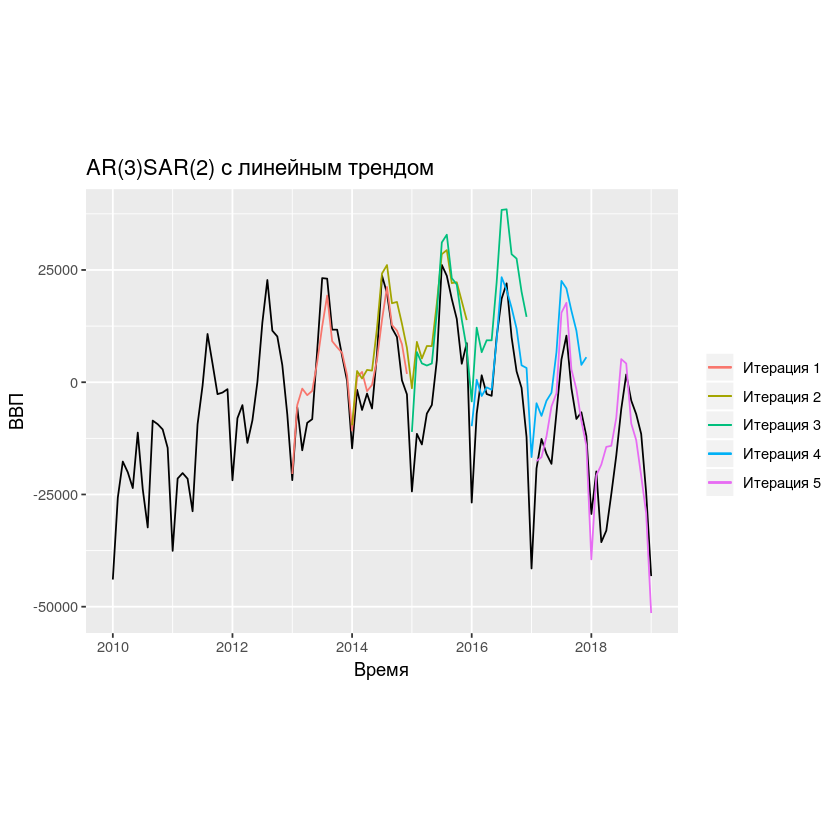

In [70]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [71]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-7124.7712  9970.5110   178.6021    25.2000

In [72]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [73]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,10496.554
2 level (state),NA,242.5226,10507.589
2 level (type),NA,241.7866,NA
2 level (clusetered),NA,241.0673,NA


In [74]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,10496.554
2 level (state),NA,242.5226,10507.589
2 level (type),NA,241.7866,9970.511
2 level (clusetered),NA,241.0673,NA


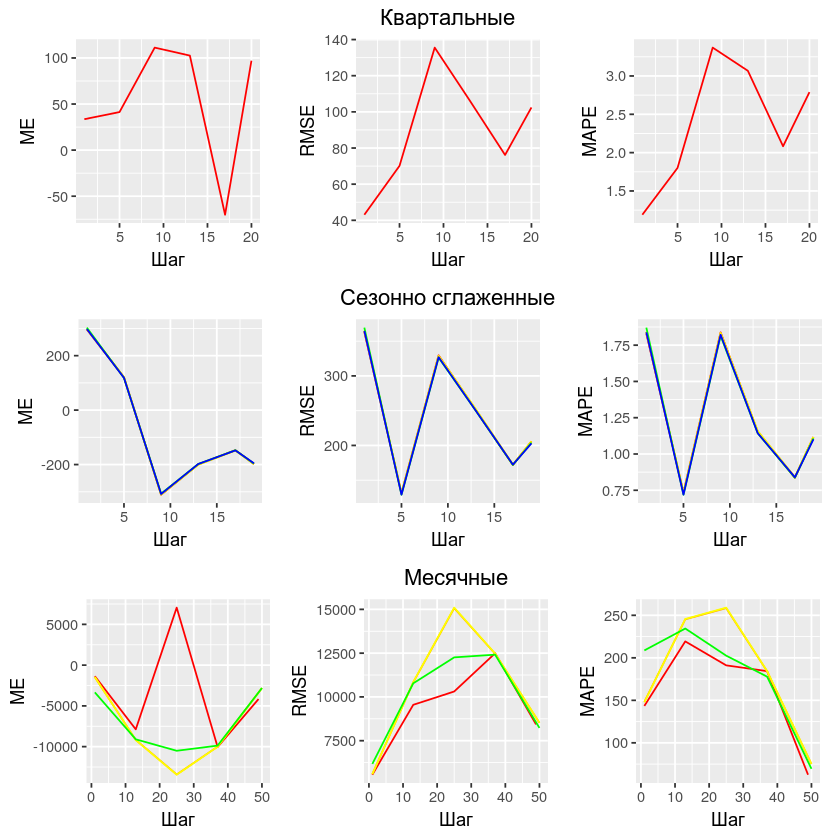

In [75]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [76]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [77]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [78]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [80]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20070.391  -4906.208  -1420.746  -2725.195  -1972.250   4420.240
 [7]  12848.347  19245.235   9324.278   8322.810   6550.224   1850.887
[13] -10322.305   1186.533   2685.289  -1572.911   -537.062   5571.513
[19]  14420.705  21277.224  13224.522  11891.071   8680.011   2554.209
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -9558.7678  2158.7473   618.5105  2519.6053  2112.1242 11794.7301
 [7] 23961.9490 25593.2505 17452.3433 17567.5200 12549.3997  7591.2286
[13] -1680.7954  8389.7679  5107.4694  7533.4150  7476.0513 17214.2151
[19] 27790.8753 28718.2896 21727.9830 21455.4613 17462.1086 13480.7782
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11145.138   6394.900   3907.309   3673.341   3982.537  15315.112
 [7]  30773.187  32185.996  22876.354  21242.114  13578.710   7387.510
[13]  -4489.488  11770.039   6452.126   9040.137   9035.608  21820.598
[19]  37531.259  37668.425  27967.255  26695.348  19643.848  14136.030
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1]  -9835.9820    457.4889  -3002.0772  -1238.4014  -1676.0012   9198.4607
 [7]  23147.9819  20473.8954  16408.6145  11791.7142   3765.2361   3180.0664
[13] -16588.4227  -4573.3393  -7407.3167  -4105.4216  -2120.1839   6586.3755
[19]  22418.9238  20907.8243  15763.8229  11495.2019   3993.4828   5564.2739
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -17463.182 -16646.840 -12073.065  -5181.254  -2430.452  15398.845
 [7]  17781.679   2771.337  -1200.134  -8170.216 -14075.735 -39023.652
[13] -20598.045 -18410.021 -14221.215 -13957.362  -8094.318   5256.631
[19]   4149.806  -9321.334 -12370.139 -20592.218 -28859.139 -50511.084
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [81]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [82]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [83]:
df_acc

ME,RMSE,MAPE,Iteration
-1617.835,5569.036,152.24984,1
-8824.969,10525.466,236.55910,13
-13219.213,14872.619,254.95885,25
-9996.342,12475.797,183.42816,37
-2988.079,8494.019,74.65812,50


In [84]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17543.501 -16707.855 -12060.477  -5403.454  -2447.611  15480.420
 [7]  17686.077   2873.435  -1555.882  -8588.390 -14117.739 -39449.691
[13] -20760.873 -18338.678 -14401.773 -14153.446  -7957.372   5141.846
[19]   4168.923  -9188.290 -12902.347 -20881.368 -29216.568 -51407.715

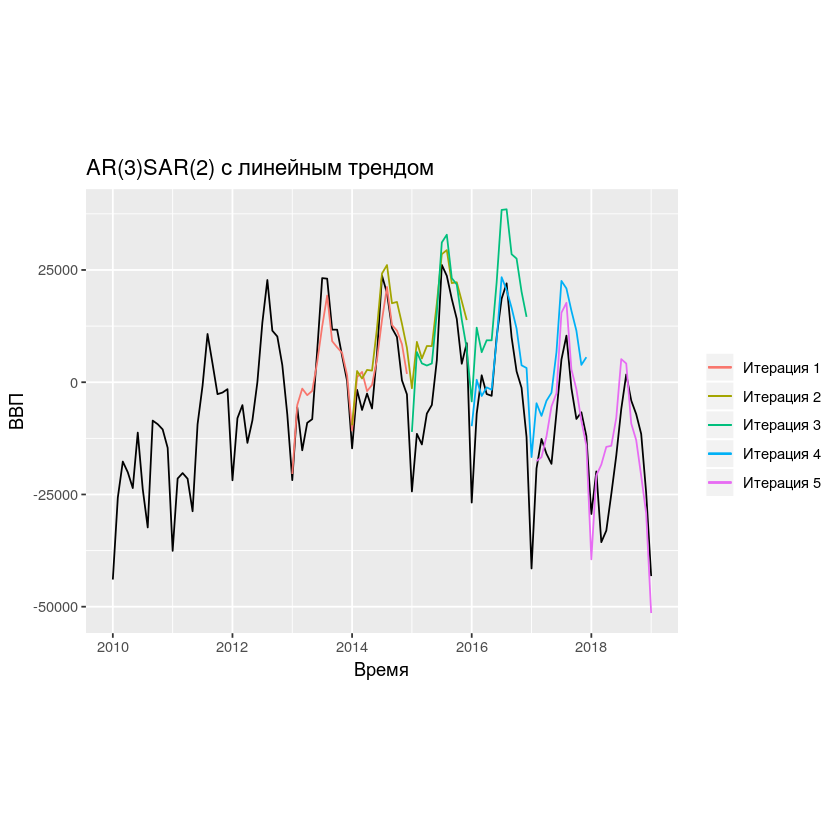

In [85]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [86]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-7329.2877 10387.3876   180.3708    25.2000

In [87]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [88]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,10496.554
2 level (state),NA,242.5226,10507.589
2 level (type),NA,241.7866,9970.511
2 level (clusetered),NA,241.0673,NA


In [89]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,10496.554
2 level (state),NA,242.5226,10507.589
2 level (type),NA,241.7866,9970.511
2 level (clusetered),NA,241.0673,10387.388


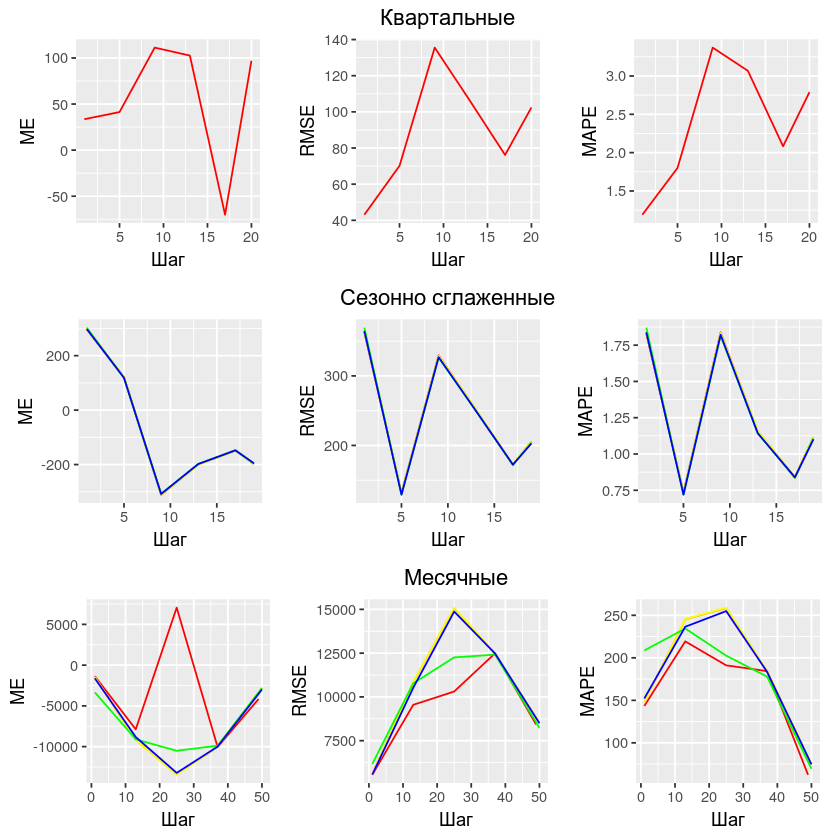

In [90]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [91]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")

In [92]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,NA,242.5226,10496.554
2 level (state),NA,242.5226,10507.589
2 level (type),NA,241.7866,9970.511
2 level (clusetered),NA,241.0673,10387.388
